# PyEumap - Land Cover Mapping (Advanced)

In this tutorial we improve the land cover mapping generating **probability** and **uncertantity** output per class, as well as an **[Ensemble Machine Learning](https://machinelearningmastery.com/what-is-ensemble-learning/)** approach and a **hyperparameter optimization** guided by the **[log_loss metric](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)**, suitable for this kind of output. Before continue, please, first execute the [Overlay](02_overlay.ipynb) and the [Land-Cover Mapping](03_landcover_mapping.ipynb) tutorials for the same tile.

This tutorial will map the follow land cover classes using the same covariates provided by the past tutorials:
* 231: Pastures,
* 312: Coniferous forest,
* 321: Natural grasslands,
* 322: Moors and heathland,
* 324: Transitional woodland-shrub,
* 332: Bare rocks,
* 333: Sparsely vegetated areas,
* 335: Glaciers and perpetual snow.

First, let's import the necessary modules

In [1]:
import sys
sys.path.append('../../')

import os
import gdal
from pathlib import Path
import pandas as pd
import geopandas as gpd
from pyeumap.mapper import LandMapper

...and load the overlaid samples for a specific tile:

In [2]:
from pyeumap import datasets

# Tile definition
tile = datasets.TILES[0]
print(f'Tile: {tile}\n\n')

# Folder setup
data_root = datasets.DATA_ROOT_NAME
data_dir = Path(os.getcwd()).joinpath(data_root,tile)

# Reading the samples
fn_points = Path(os.getcwd()).joinpath(data_dir, tile + '_landcover_samples_overlayed.gpkg')
points = gpd.read_file(fn_points)
points.head()

Tile: 10636_switzerland




,lucas,survey_date,confidence,tile_id,lc_class,overlay_id,dtm_elevation,dtm_slope,landsat_ard_winter_blue_p75,landsat_ard_fall_green_p25,...,landsat_ard_winter_thermal_p75,landsat_ard_fall_thermal_p75,landsat_ard_winter_blue_p25,landsat_ard_spring_blue_p50,landsat_ard_summer_thermal_p75,landsat_ard_winter_blue_p50,landsat_ard_spring_thermal_p75,landsat_ard_summer_blue_p25,landsat_ard_fall_blue_p25,geometry
0,False,2006-06-30T00:00:00,85,10636,321,1,1948.0,36.313705,136.0,16.0,...,176.0,186.0,128.0,11.0,183.0,130.0,185.0,8.0,5.0,POINT (4145221.759 2594636.440)
1,False,2006-06-30T00:00:00,85,10636,321,2,2209.0,7.917305,118.0,17.0,...,176.0,183.0,118.0,120.0,182.0,118.0,177.0,5.0,5.0,POINT (4142366.664 2598169.380)
2,False,2006-06-30T00:00:00,85,10636,321,3,1990.0,32.722038,131.0,12.0,...,179.0,188.0,100.0,10.0,185.0,116.0,185.0,9.0,4.0,POINT (4140249.007 2596954.755)
3,False,2006-06-30T00:00:00,85,10636,322,4,2142.0,49.800537,48.0,4.0,...,176.0,179.0,48.0,37.0,179.0,48.0,172.0,2.0,7.0,POINT (4148638.412 2595538.585)
4,False,2006-06-30T00:00:00,85,10636,332,5,2420.0,27.018671,228.0,29.0,...,178.0,188.0,228.0,201.0,188.0,228.0,176.0,16.0,16.0,POINT (4156286.754 2595790.720)


## Probability output

Considering that a probability output provides diferent levels of classification for the target classes, it's recommended a diferent evaluation metric for the the hyperparameter optimization. Here we choosen **[log_loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) (logistic loss or cross-entropy loss)**, however you can find more options in [scikit-learn - Classification Metrics](https://scikit-learn.org/stable/modules/classes.html#classification-metrics) (hinge_loss, brier_score_loss).

Unlike the F1-Score, a lower log_loss is better for the optimization process, and because of that we will multiply by **-1** the returned error.

In [3]:
from sklearn.metrics import log_loss

def log_loss_scorer(clf, X, y_true):
    class_labels = clf.classes_
    y_pred_proba = clf.predict_proba(X)
    error = log_loss(y_true, y_pred_proba, labels=class_labels)
    return error * -1

We will use the same classification algorithm, hyperparameter possibilities and cv strategy of the past tutorial:

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=100)

hyperpar = GridSearchCV(
    estimator = estimator,
    scoring = log_loss_scorer,
    param_grid = {
     'min_samples_leaf': [1, 5],
     'max_depth': [5, None], 
     'max_features': [0.5]
    }
)

Now let's create a new instance for the LandMapper class passing one aditional parameter:
* ***pred_method***: The predict_proba will change the model output for a lc-class probabilities.

In [5]:
feat_col_prfxs = ['landsat', 'dtm', 'night_lights']
target_col = 'lc_class'
weight_col = 'confidence'

min_samples_per_class = 0.05
cv = 5

landmapper_prob = LandMapper(points=points, 
                        feat_col_prfxs = feat_col_prfxs, 
                        target_col = target_col, 
                        estimator = estimator, 
                        hyperpar_selection = hyperpar,
                        cv = cv,
                        min_samples_per_class=min_samples_per_class,
                        pred_method='predict_proba',
                        weight_col=weight_col,
                        verbose = True)

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


[14:39:06] Removing 74 samples due min_samples_per_class condition (< 0.05)
[14:39:06] Transforming lc_class:
[14:39:06]  -Original classes: [231. 312. 321. 322. 324. 332. 333. 335.]
[14:39:06]  -Transformed classes: [0 1 2 3 4 5 6 7]


Notice that the **original classes** were remaped for a **sequential class values** using [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), which can be accessed in the property *target_le*:

In [6]:
landmapper_prob.target_le

LabelEncoder()

Time to run (*If it's taking too long try to reduce the hyperparameters possibilities and/or the cv=2*):

In [7]:
landmapper_prob.train()

[14:39:06] Optimizing hyperparameters for RandomForestClassifier
[14:39:31]  1.04401 (+/-0.06138) from {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 1}
[14:39:31]  1.04985 (+/-0.06124) from {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 5}
[14:39:31]  0.81035 (+/-0.19313) from {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1}
[14:39:31]  0.87019 (+/-0.07931) from {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 5}
[14:39:31] Best: -0.81035 using {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1}
[14:39:31] Calculating evaluation metrics


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[14:39:39] Training RandomForestClassifier using all samples


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.2s finished


Now let's take a look in the classification report.

In [8]:
print(f'Log loss: {landmapper_prob.eval_metrics["log_loss"]:.3f}\n\n')
print(landmapper_prob.eval_report)

Log loss: 0.807


     log_loss   pr_auc   optimal_prob  optimal_precision  optimal_recall  support

0  0.8597     0.8292   0.3400        0.6667              0.6875         66
1  0.6349     0.7982   0.4300        0.7236              0.7129         199
2  0.8343     0.8045   0.3600        0.7651              0.7560         166
3  1.3004     0.5415   0.3000        0.5776              0.5776         116
4  1.6580     0.3433   0.2800        0.3452              0.3537         84
5  0.6934     0.7934   0.3590        0.7723              0.7723         101
6  0.5372     0.8865   0.4200        0.8166              0.8166         229
7  0.4806     0.9769   0.5200        0.9663              0.9663         89

Total                                                                     1050



Let's understand this report.

Using the cv result, the LandMapper calculated the **log_loss** and the **[pr_auc (area under the precision recall curve)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve)** for each class. The pr_auc information was used to choose the **best probability** value to derive a hard classification output, balancing the **precision** (*producer's accuracy or the class understimation*) and **recall** (*user's accuracy or the class overestimation*), thus minimizing the bias in the land cover area estimation. For more infomation about the precision recall curve [access this link](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/).

All the probabilities metrics are available through the ``prob_metrics`` property

In [9]:
list(landmapper_prob.prob_metrics.keys())

['log_loss',
 'pr_auc',
 'support',
 'opti_th',
 'opti_recall',
 'opti_precision',
 'curv_recall',
 'curv_precision',
 'curv_th']

...and it's possible to use the raw cv results to derive other evaluation metrics as [hinge_loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hinge_loss.html):

In [10]:
from sklearn import preprocessing, metrics

# Tranform the target classes in probability values
lb = preprocessing.LabelBinarizer()
targ_prob = lb.fit_transform(landmapper_prob.target)
n_classes = len(lb.classes_)

# Brier loss calculation for each class
print('Brier loss:')
for c in range(0,n_classes):
    brier_loss = metrics.brier_score_loss(targ_prob[:,c], landmapper_prob.eval_pred[:,c])
    print(f' - {lb.classes_[c]:.0f}: {brier_loss * 100:.3f}%')

Brier loss:
 - 0: 2.552%
 - 1: 7.144%
 - 2: 6.503%
 - 3: 6.776%
 - 4: 6.148%
 - 5: 3.494%
 - 6: 6.417%
 - 7: 0.681%


# EML (Emsemble Machine Learning) and uncertainties

Up until now only one estimator was used to produce the land cover maps. Even considering that the Random Forest is a emsemble of [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), the trees growth uses the same rationale to train a weak estimator considering different proportions of the full dataset ([Bagging approach](https://stats.stackexchange.com/a/19053)). A combination of the Random Forest with other estimators will produce multiple predicted values, produced by different approachs/algorithms that consequently splits the feature space in a diferent way, allowing the derivation of a final probability and a uncertanty estimative, based in the standard deviation of all predicted probabilties

To do it, let's first create our traditional estimator:

In [11]:
estimator_rf = RandomForestClassifier(n_jobs=-1, n_estimators=85)

hyperpar_rf = GridSearchCV(
    estimator = estimator_rf,
    scoring = log_loss_scorer,
    param_grid = {
     'max_depth': [5, None], 
     'max_features': [0.5, None]
    }
)

In addition to Random Forest we will use the [XGBoost](https://xgboost.readthedocs.io/en/latest/)

In [12]:
import xgboost as xgb
estimator_bgtree = xgb.XGBClassifier(n_jobs=-1, n_estimators=28, objective='multi:softmax', eval_metric='mlogloss', booster='gbtree')

hyperpar_bgtree = GridSearchCV(
    estimator = estimator_bgtree,
    scoring = log_loss_scorer,
    param_grid = {
     'eta': [0.001, 0.9], 
     'alpha': [0, 10]
    }
)

...and a regular ANN (Artificial Neural Network) through [KerasClassifier](https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasClassifier):

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from pyeumap.misc import build_ann

input_shape = 87
n_classes = 8
estimator_ann = Pipeline([
	('standardize', StandardScaler()),
	('estimator', KerasClassifier(build_ann, input_shape=input_shape, output_shape=n_classes, \
		epochs=5, batch_size=64, learning_rate = 0.0005, \
		dropout_rate=0.15, n_layers = 4, n_neurons=64, shuffle=True, verbose=False))
])

hyperpar_ann = GridSearchCV(
    estimator = estimator_ann,
    scoring = log_loss_scorer,
    param_grid = {
     'estimator__dropout_rate': [0, 0.15], 
     'estimator__n_layers': [2, 4]
    }
)

It's important to choose modern estimators able to produce results **equally accurate** and **comparable** to the *Random Forest*, otherwise they could produce a poor classification results at end.

The three predicted probabilities will be combined by a meta-estimator, which will receive as **n_estimator * n_classes** covariates/features as input and produce the final output:

In [14]:
from sklearn.linear_model import LogisticRegression

meta_estimator = LogisticRegression(solver='saga', multi_class='multinomial')

hyperpar_meta = GridSearchCV(
    estimator = meta_estimator,
    scoring = log_loss_scorer,
    param_grid = {
        'fit_intercept': [False, True],
        'C': [0.5, 1]
    }
)

To pass the three estimators and their respective hyperparameter optimization critereas we will use ``estimator_list`` and ``hyperpar_selection_list``, using the same element orders for both:

In [15]:
feat_col_prfxs = ['landsat', 'dtm', 'night_lights']
target_col = 'lc_class'
weight_col = 'confidence'

min_samples_per_class = 0.05
cv = 2

estimator_list = [estimator_rf, estimator_bgtree, estimator_ann]
hyperpar_selection_list = [hyperpar_rf, hyperpar_bgtree, hyperpar_ann]

landmapper_eml = LandMapper(points=fn_points, 
                        feat_col_prfxs = feat_col_prfxs, 
                        target_col = target_col, 
                        estimator_list = estimator_list, 
                        meta_estimator = meta_estimator,
                        hyperpar_selection_list = hyperpar_selection_list,
                        hyperpar_selection_meta = hyperpar_meta,
                        min_samples_per_class = min_samples_per_class,
                        cv = cv,
                        verbose = True)

[14:39:41] Removing 74 samples due min_samples_per_class condition (< 0.05)
[14:39:41] Transforming lc_class:
[14:39:41]  -Original classes: [231. 312. 321. 322. 324. 332. 333. 335.]
[14:39:41]  -Transformed classes: [0 1 2 3 4 5 6 7]


Time to train our EML estimator:

In [16]:
landmapper_eml.train()

[14:39:41] Optimizing hyperparameters for RandomForestClassifier
[14:39:46]  1.04221 (+/-0.00419) from {'max_depth': 5, 'max_features': 0.5}
[14:39:46]  1.02002 (+/-0.00445) from {'max_depth': 5, 'max_features': None}
[14:39:46]  0.85185 (+/-0.09185) from {'max_depth': None, 'max_features': 0.5}
[14:39:46]  0.87241 (+/-0.16284) from {'max_depth': None, 'max_features': None}
[14:39:46] Best: -0.85185 using {'max_depth': None, 'max_features': 0.5}
[14:39:46] Optimizing hyperparameters for XGBClassifier
[14:39:51]  2.03734 (+/-0.00103) from {'alpha': 0, 'eta': 0.001}
[14:39:51]  1.02664 (+/-0.23665) from {'alpha': 0, 'eta': 0.9}
[14:39:51]  2.05211 (+/-0.00136) from {'alpha': 10, 'eta': 0.001}
[14:39:51]  1.16382 (+/-0.07983) from {'alpha': 10, 'eta': 0.9}
[14:39:51] Best: -1.02664 using {'alpha': 0, 'eta': 0.9}
[14:39:51] Optimizing hyperparameters for Pipeline
[14:40:26]  1.76417 (+/-0.03020) from {'estimator__dropout_rate': 0, 'estimator__n_layers': 2}
[14:40:26]  1.85745 (+/-0.03881) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[14:40:35]  Meta-features shape: (1050, 24)
[14:40:35] Optimizing hyperparameters for LogisticRegression


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.0s finished


[14:40:36]  0.87106 (+/-0.05371) from {'C': 0.5, 'fit_intercept': False}
[14:40:36]  0.87016 (+/-0.05092) from {'C': 0.5, 'fit_intercept': True}
[14:40:36]  0.85232 (+/-0.05337) from {'C': 1, 'fit_intercept': False}
[14:40:36]  0.85179 (+/-0.05078) from {'C': 1, 'fit_intercept': True}
[14:40:36] Best: -0.85179 using {'C': 1, 'fit_intercept': True}
[14:40:36] Calculating evaluation metrics
[14:40:36] Training RandomForestClassifier using all samples


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


[14:40:36] Training XGBClassifier using all samples
[14:40:37] Training Pipeline using all samples
[14:40:40] Training meta-estimator using all samples


...and about the classification report?

In [17]:
print(f'Log loss: {landmapper_eml.eval_metrics["log_loss"]:.3f}\n\n')
print(landmapper_eml.eval_report)

Log loss: 0.852


     log_loss   pr_auc   optimal_prob  optimal_precision  optimal_recall  support

0  0.9498     0.7811   0.2781        0.7576              0.7576         66
1  0.7917     0.7690   0.4617        0.6884              0.6884         199
2  0.8634     0.7672   0.3637        0.7229              0.7229         166
3  1.4147     0.5178   0.2657        0.5000              0.5000         116
4  1.7995     0.2645   0.2202        0.2738              0.2738         84
5  0.7486     0.7716   0.3791        0.7624              0.7624         101
6  0.5129     0.8934   0.4102        0.7991              0.7991         229
7  0.2529     0.9740   0.6095        0.9438              0.9438         89

Total                                                                     1050



Now we are ready to run the predictions passing the follow parameters:
* **dirs_layers**: a list containing diferent folders that store the same raster layers used in the spacetive overlay and training phase,
* **fn_output**: the file path to write the model output as geotiff.

In [18]:
dir_timeless_layers = os.path.join(data_dir, 'timeless') 
dir_2000_layers = os.path.join(data_dir, '2000')

dirs_layers = [dir_2000_layers, dir_timeless_layers]
fn_output = os.path.join(data_dir, 'land_cover_eml_2000.tif')

output_fn_files = landmapper_eml.predict(dirs_layers=dirs_layers, fn_output=fn_output)

print('Output files:')
for output_fn_file in output_fn_files:
    print(f' - {Path(output_fn_file).name}')

[14:40:40] Reading 87 raster files
[14:40:46] Executing RandomForestClassifier
[14:40:48] RandomForestClassifier prediction time: 2.55 segs
[14:40:48] Executing XGBClassifier
[14:40:50] XGBClassifier prediction time: 1.86 segs
[14:40:50] Executing Pipeline
[14:40:50] batch_size=500000
[14:40:54] Pipeline prediction time: 3.87 segs
[14:40:54] Executing LogisticRegression
[14:40:55] LogisticRegression prediction time: 1.17 segs
Output files:
 - land_cover_eml_2000_b1.tif
 - land_cover_eml_2000_b2.tif
 - land_cover_eml_2000_b3.tif
 - land_cover_eml_2000_b4.tif
 - land_cover_eml_2000_b5.tif
 - land_cover_eml_2000_b6.tif
 - land_cover_eml_2000_b7.tif
 - land_cover_eml_2000_b8.tif
 - land_cover_eml_2000_hcl.tif
 - land_cover_eml_2000_hcl_prob.tif
 - land_cover_eml_2000_uncertainty_b1.tif
 - land_cover_eml_2000_uncertainty_b2.tif
 - land_cover_eml_2000_uncertainty_b3.tif
 - land_cover_eml_2000_uncertainty_b4.tif
 - land_cover_eml_2000_uncertainty_b5.tif
 - land_cover_eml_2000_uncertainty_b6.t

Let's understand the output files:
* **Probabilities/Uncertainties**: For each land cover class was generated a raster file with the predicted probability/uncertainty. The output filename is equal defined by ``{fn_output}_b{target_class_transformed}.tif``
* **Dominant/Hard classes**: The dominant/hard class file (``*hcl.tif``) was generated assuming the highest probability value as final class. The ``*hcl_prob.tif`` presents the probability of the chosen land cover class.

It's possible access the **original** and **transformed** values in the property ``target_classes``:

In [19]:
labels = [
    '231: Pastures',
    '312: Coniferous forest',
    '321: Natural grasslands',
    '322: Moors and heathland',
    '324: Transitional woodland-shrub',
    '332: Bare rocks',
    '333: Sparsely vegetated areas',
    '335: Glaciers and perpetual snow'
]

pd.DataFrame({
    'Label':labels,
    'Original': landmapper_eml.target_classes['original'],
    'Transformed': landmapper_eml.target_classes['transformed']
})

,Label,Original,Transformed
0,231: Pastures,231.0,0
1,312: Coniferous forest,312.0,1
2,321: Natural grasslands,321.0,2
3,322: Moors and heathland,322.0,3
4,324: Transitional woodland-shrub,324.0,4
5,332: Bare rocks,332.0,5
6,333: Sparsely vegetated areas,333.0,6
7,335: Glaciers and perpetual snow,335.0,7


Let's see the the probability and uncertainty outputs:

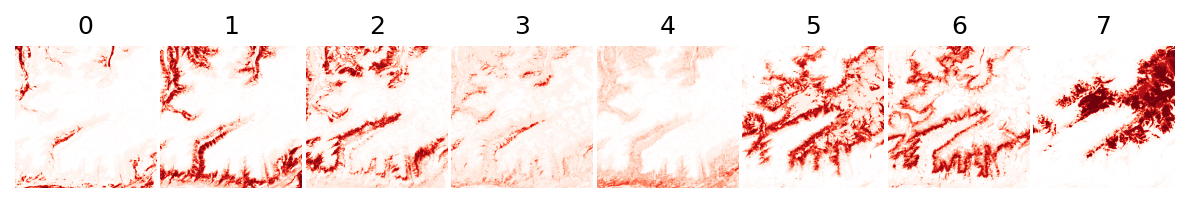

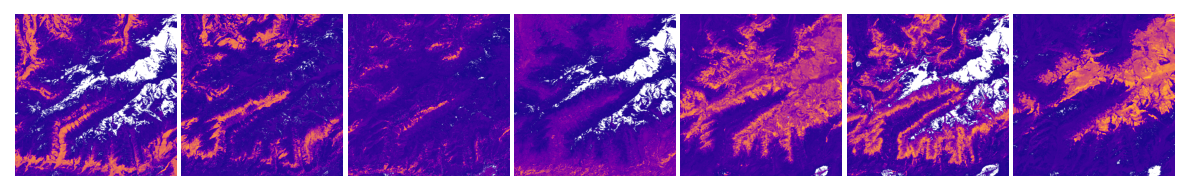

In [20]:
import numpy as np
from pyeumap.plotter import plot_rasters

lc_classes = [ int(c) for c in landmapper_eml.target_classes['transformed']]

plot_rasters(*output_fn_files[0:8], cmaps='Reds', titles=lc_classes)
plot_rasters(*output_fn_files[11:19], cmaps='plasma')

...and the dominant land cover:

Mapped land cover classes
 - 231 => pixel value 0 (red)
 - 312 => pixel value 1 (darkred)
 - 321 => pixel value 2 (springgreen)
 - 322 => pixel value 3 (green)
 - 324 => pixel value 4 (darkgreen)
 - 332 => pixel value 5 (yellow)
 - 333 => pixel value 6 (tan)
 - 335 => pixel value 7 (white)


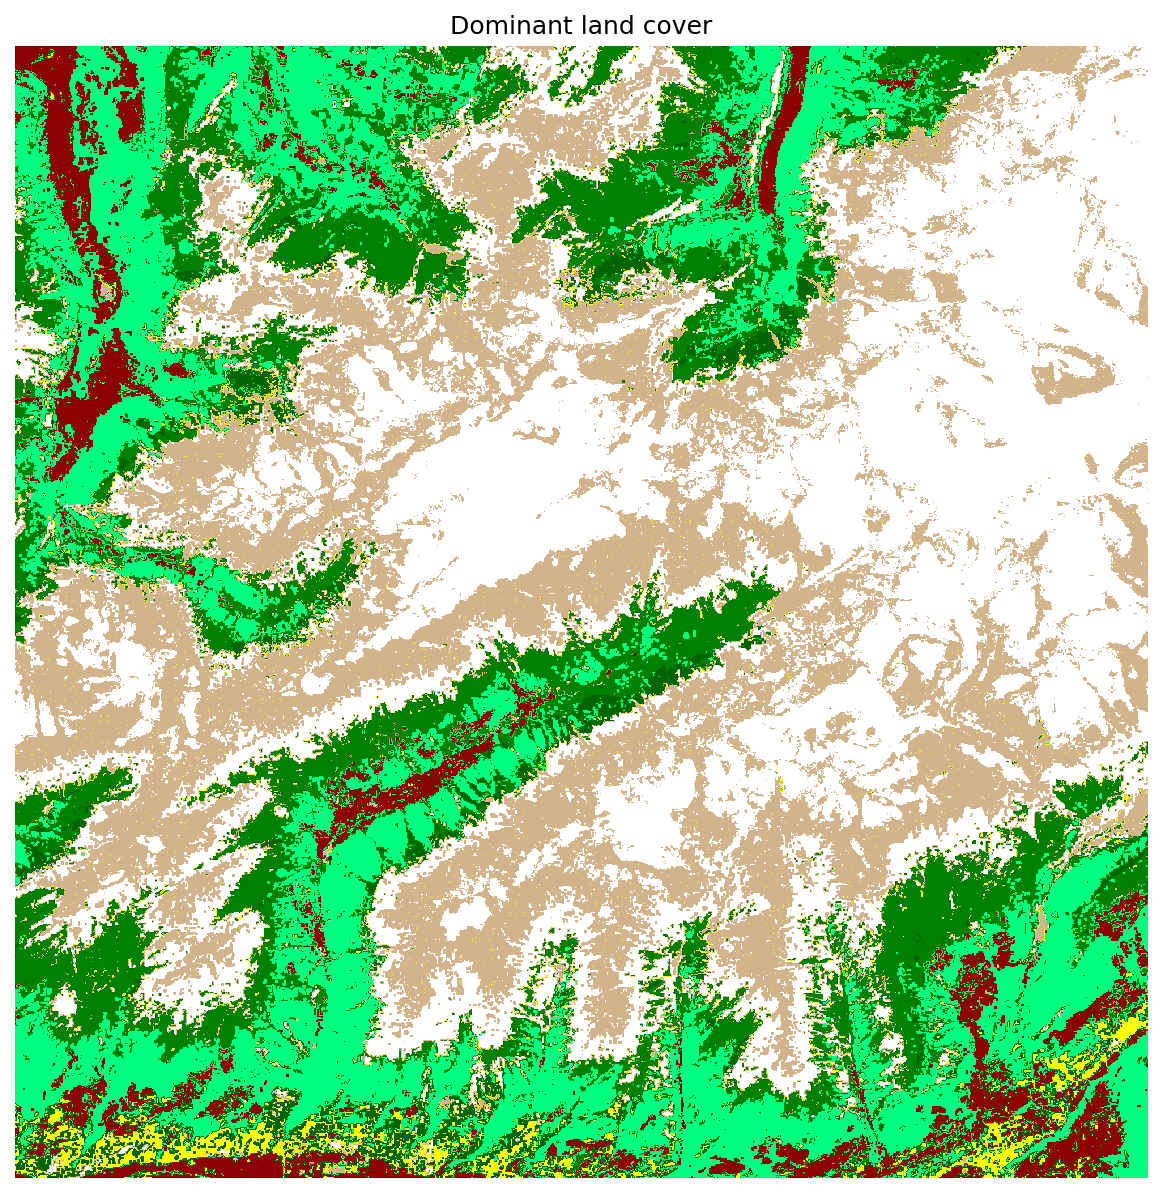

In [21]:
from pyeumap.plotter import plot_rasters
import numpy as np
from matplotlib.colors import ListedColormap

lc_classes = landmapper_eml.target_classes['original']
pixel_values = landmapper_eml.target_classes['transformed']
colors = ListedColormap(["red", "darkred", "springgreen", "green", "darkgreen", "yellow", "tan", "white"])

print("Mapped land cover classes")
for l, p, c in zip(lc_classes, pixel_values, colors.colors):
    print(f' - {l:.0f} => pixel value {p} ({c})')

plot_rasters(output_fn_files[8], cmaps = colors, titles = 'Dominant land cover')

Time to predict multiple years creating a list of **dirs_layers** and **fn_output** and passing to the method **predict_multi**, which will perform this task in parallel:

In [22]:
dir_timeless_layers = os.path.join(data_dir, 'timeless') 

dirs_layers_list = []
fn_output_list = []

for year in range(2000, 2003):
    dir_time_layers = os.path.join(data_dir, str(year))
    dirs_layers = [dir_time_layers, dir_timeless_layers]
    fn_result = os.path.join(data_dir, f'land_cover_eml_{year}.tif')
    
    dirs_layers_list.append(dirs_layers)
    fn_output_list.append(fn_result)

output_fn_files = landmapper_eml.predict_multi(dirs_layers_list=dirs_layers_list, fn_output_list=fn_output_list)

print('Output files:')
for output_fn_file in output_fn_files:
    print(f' - {Path(output_fn_file).name}')

[14:40:59] Reading 87 raster files
[14:41:05] 1) Reading time: 5.68 segs
[14:41:05] 1) Predicting 1000000 pixels
[14:41:05] Reading 87 raster files
[14:41:05] Executing RandomForestClassifier
[14:41:08] RandomForestClassifier prediction time: 3.07 segs
[14:41:08] Executing XGBClassifier
[14:41:11] XGBClassifier prediction time: 2.24 segs
[14:41:11] Executing Pipeline
[14:41:11] batch_size=500000
[14:41:11] 2) Reading time: 5.91 segs
[14:41:11] Reading 87 raster files
[14:41:15] Pipeline prediction time: 4.07 segs
[14:41:15] Executing LogisticRegression
[14:41:16] LogisticRegression prediction time: 1.40 segs
[14:41:16] 1) Predicting time: 10.83 segs
[14:41:16] 2) Predicting 1000000 pixels
[14:41:17] 3) Reading time: 5.71 segs
[14:41:17] Executing RandomForestClassifier
[14:41:17] 1) Saving time: 0.76 segs
[14:41:19] RandomForestClassifier prediction time: 2.65 segs
[14:41:19] Executing XGBClassifier
[14:41:21] XGBClassifier prediction time: 1.88 segs
[14:41:21] Executing Pipeline
[14:4

The ``LandMapper`` also supports a **eager** prediction strategy that *reads all the years*, run the predictions for all the data *at once* and write the output files:

In [23]:
from pyeumap.mapper import PredictionStrategyType

pred_strategy_type = PredictionStrategyType.Eager
output_fn_files = landmapper_eml.predict_multi(dirs_layers_list=dirs_layers_list, fn_output_list=fn_output_list, prediction_strategy_type=pred_strategy_type)

print('Output files:')
for output_fn_file in output_fn_files:
    print(f' - {Path(output_fn_file).name}')

[14:41:36] Reading 87 raster files
[14:41:36] [14:41:36] Reading 87 raster files
Reading 87 raster files
[14:41:44] 1) Reading time: 7.32 segs
[14:41:44] 3) Reading time: 7.44 segs
[14:41:44] 2) Reading time: 7.98 segs
[14:41:44] 3) Predicting 3000000 pixels
[14:41:45] Executing RandomForestClassifier
[14:41:53] RandomForestClassifier prediction time: 7.71 segs
[14:41:53] Executing XGBClassifier
[14:41:58] XGBClassifier prediction time: 5.30 segs
[14:41:58] Executing Pipeline
[14:41:58] batch_size=1500000
[14:42:10] Pipeline prediction time: 11.87 segs
[14:42:10] Executing LogisticRegression
[14:42:13] LogisticRegression prediction time: 3.40 segs
[14:42:14] 3) Predicting time: 28.41 segs
[14:42:16] 3) Saving time: 2.39 segs
[14:42:16] 2) Saving time: 2.39 segs
[14:42:16] 1) Saving time: 2.45 segs
Output files:
 - land_cover_eml_2000_b1.tif
 - land_cover_eml_2000_b2.tif
 - land_cover_eml_2000_b3.tif
 - land_cover_eml_2000_b4.tif
 - land_cover_eml_2000_b5.tif
 - land_cover_eml_2000_b6.t

## Feature Selection

The ``LandMapper`` is fully compatible with scikit-learn, supporting any [BaseEstimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html) and [Pipeline](https://scikit-learn.org/stable/modules/compose.html#pipeline) implementations. 

To demonstrate it, we will develop from scratch a simple **random feature selection strategy**, which will randomly reduce the number of input features before the training step.

In [24]:
from numpy.random import default_rng
from sklearn.base import BaseEstimator, TransformerMixin

class RandomFeatureSelector(TransformerMixin, BaseEstimator):

    def __init__(self, n_features = 10, seed = 0):
        self.n_features = n_features
        self.rng = default_rng()
        self.seed = seed

    def fit(self, X, y):
        n_features = X.shape[1]
        self.rand_features = self.rng.choice(n_features, size=self.n_features, replace=False)
        return self

    def transform(self, X):
        return X[:,self.rand_features]

Now let's define the expected **number of features** (*there are 87 features in total*), changing the input ``seed`` to produce diferent subsets. The ``passthrough`` will indicate to the pipeline just move foward to the next step.

In [25]:
feature_sel = [
    RandomFeatureSelector(n_features=60, seed = 0),
    RandomFeatureSelector(n_features=70, seed = 0),
    RandomFeatureSelector(n_features=80, seed = 0),
    RandomFeatureSelector(n_features=60, seed = 1),
    RandomFeatureSelector(n_features=70, seed = 1),
    RandomFeatureSelector(n_features=80, seed = 1),
    'passthrough'
]

This time we will define our estimators as [pipelines](https://scikit-learn.org/stable/modules/compose.html#pipeline), indicating the ``feature_sel`` step before them

In [26]:
estimator_rf = Pipeline([
    ('feature_sel', 'passthrough'),
    ('estimator', RandomForestClassifier(n_jobs=-1, max_depth=None,  n_estimators=85))
])

estimator_bgtree = Pipeline([
    ('feature_sel', 'passthrough'),
    ('estimator', xgb.XGBClassifier(n_jobs=-1, n_estimators=28, objective='multi:softmax', eval_metric='mlogloss', booster='gbtree'))
])

estimator_ann = Pipeline([
    ('feature_sel', 'passthrough'),
    ('standardize', StandardScaler()),
    ('estimator', KerasClassifier(build_ann, input_shape=input_shape, output_shape=n_classes, \
        epochs=5, batch_size=64, learning_rate = 0.0005, \
        dropout_rate=0.15, n_layers = 4, n_neurons=64, shuffle=True, verbose=False))
])

...and adding the ``feature_sel`` possibilities as a property in our hyperparameter optimization class (GridSearchCV):

In [27]:
hyperpar_rf = GridSearchCV(
    estimator = estimator_rf,
    scoring = log_loss_scorer,
    verbose = True,
    param_grid = {
     'feature_sel': feature_sel,
     'estimator__max_depth': [5, None], 
     'estimator__max_features': [0.5, None]
    }
)

hyperpar_bgtree = GridSearchCV(
    estimator = estimator_bgtree,
    scoring = log_loss_scorer,
    verbose = True,
    param_grid = {
     'feature_sel': feature_sel,
     'estimator__eta': [0.001, 0.9], 
     'estimator__alpha': [0, 10]
    }
)

hyperpar_ann = GridSearchCV(
    estimator = estimator_ann,
    scoring = log_loss_scorer,
    verbose = True,
    param_grid = {
     'feature_sel': feature_sel,
     'estimator__dropout_rate': [0, 0.15], 
     'estimator__n_layers': [2, 4]
    }
)

Let's keep the **same** meta-estimator

In [28]:
meta_estimator = LogisticRegression(solver='saga', multi_class='multinomial', C=1, fit_intercept=True)

... and ``LandMapper`` parameters:

In [29]:
feat_col_prfxs = ['landsat', 'dtm', 'night_lights']
target_col = 'lc_class'
weight_col = 'confidence'

min_samples_per_class = 0.05
cv = 2

landmapper_feat_sel = LandMapper(points=fn_points, 
                                feat_col_prfxs = feat_col_prfxs, 
                                target_col = target_col, 
                                estimator_list = [estimator_rf, estimator_bgtree, estimator_ann],
                                hyperpar_selection_list = [hyperpar_rf, hyperpar_bgtree, hyperpar_ann],
                                meta_estimator = meta_estimator,
                                min_samples_per_class = min_samples_per_class,
                                cv = cv,
                                pred_method='predict_proba',
                                verbose = True)

landmapper_feat_sel.train()

[14:42:17] Removing 74 samples due min_samples_per_class condition (< 0.05)
[14:42:17] Transforming lc_class:
[14:42:17]  -Original classes: [231. 312. 321. 322. 324. 332. 333. 335.]
[14:42:17]  -Transformed classes: [0 1 2 3 4 5 6 7]
[14:42:17] Optimizing hyperparameters for Pipeline
Fitting 2 folds for each of 28 candidates, totalling 56 fits
[14:42:37]  1.02960 (+/-0.01770) from {'estimator__max_depth': 5, 'estimator__max_features': 0.5, 'feature_sel': RandomFeatureSelector(n_features=60)}
[14:42:37]  1.07709 (+/-0.05853) from {'estimator__max_depth': 5, 'estimator__max_features': 0.5, 'feature_sel': RandomFeatureSelector(n_features=70)}
[14:42:37]  1.03694 (+/-0.00759) from {'estimator__max_depth': 5, 'estimator__max_features': 0.5, 'feature_sel': RandomFeatureSelector(n_features=80)}
[14:42:37]  1.10379 (+/-0.00124) from {'estimator__max_depth': 5, 'estimator__max_features': 0.5, 'feature_sel': RandomFeatureSelector(n_features=60, seed=1)}
[14:42:37]  1.09304 (+/-0.00272) from {'e

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[14:47:11]  Meta-features shape: (1050, 24)
[14:47:11] Calculating evaluation metrics


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished


[14:47:11] Training Pipeline using all samples
[14:47:12] Training Pipeline using all samples
[14:47:12] Training Pipeline using all samples
[14:47:15] Training meta-estimator using all samples


Checking the output it's possible to see that **some variables** were **removed**. 

How it impacts the accuracy metrics?

In [30]:
print(f'Log loss: {landmapper_feat_sel.eval_metrics["log_loss"]:.3f}\n\n')
print(landmapper_feat_sel.eval_report)

Log loss: 0.827


     log_loss   pr_auc   optimal_prob  optimal_precision  optimal_recall  support

0  0.9037     0.8317   0.3136        0.7727              0.7727         66
1  0.7376     0.7676   0.4981        0.7035              0.7035         199
2  0.8441     0.7785   0.3907        0.7410              0.7410         166
3  1.4253     0.4959   0.2263        0.5172              0.5172         116
4  1.7387     0.2986   0.2329        0.3452              0.3452         84
5  0.7297     0.7978   0.3399        0.7624              0.7624         101
6  0.5004     0.8996   0.4732        0.8341              0.8341         229
7  0.2475     0.9829   0.4640        0.9326              0.9326         89

Total                                                                     1050



Even using less features in the estimator, the prediction needs receive the **full feature space** (*all rasters*), which will be reduced by the pipeline (``feature_sel`` step):

In [31]:
dir_timeless_layers = os.path.join(data_dir, 'timeless') 
dir_2000_layers = os.path.join(data_dir, '2000')

dirs_layers = [dir_2000_layers, dir_timeless_layers]
fn_output = os.path.join(data_dir, 'land_cover_eml_featsel_2000.tif')

output_fn_files = landmapper_feat_sel.predict(dirs_layers=dirs_layers, fn_output=fn_output)

print('Output files:')
for output_fn_file in output_fn_files:
    print(f' - {Path(output_fn_file).name}')

[14:47:16] Reading 87 raster files
[14:47:21] Executing Pipeline
[14:47:24] Pipeline prediction time: 3.16 segs
[14:47:24] Executing Pipeline
[14:47:27] Pipeline prediction time: 2.51 segs
[14:47:27] Executing Pipeline
[14:47:27] batch_size=500000
[14:47:31] Pipeline prediction time: 3.67 segs
[14:47:31] Executing LogisticRegression
[14:47:32] LogisticRegression prediction time: 1.22 segs
Output files:
 - land_cover_eml_featsel_2000_b1.tif
 - land_cover_eml_featsel_2000_b2.tif
 - land_cover_eml_featsel_2000_b3.tif
 - land_cover_eml_featsel_2000_b4.tif
 - land_cover_eml_featsel_2000_b5.tif
 - land_cover_eml_featsel_2000_b6.tif
 - land_cover_eml_featsel_2000_b7.tif
 - land_cover_eml_featsel_2000_b8.tif
 - land_cover_eml_featsel_2000_hcl.tif
 - land_cover_eml_featsel_2000_hcl_prob.tif
 - land_cover_eml_featsel_2000_uncertainty_b1.tif
 - land_cover_eml_featsel_2000_uncertainty_b2.tif
 - land_cover_eml_featsel_2000_uncertainty_b3.tif
 - land_cover_eml_featsel_2000_uncertainty_b4.tif
 - land

## VotingClassifier

Next, we will construct a EML using a [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html):

In [32]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

voting_eml = VotingClassifier([
    ('rf', RandomForestClassifier(n_jobs=-1, max_depth=None,  n_estimators=85)),
    ('svm', SVC(probability=True, cache_size=1024)),
    ('xgb', xgb.XGBClassifier(n_jobs=-1, n_estimators=28, objective='multi:softmax', eval_metric='mlogloss', booster='gbtree')),
], voting='soft')

hyperpar_voting_eml = GridSearchCV(
    estimator = voting_eml,
    scoring = log_loss_scorer,
    verbose = True,
    param_grid = {
     'svm__C': [1, 1.5],
     'svm__kernel': ['rbf', 'poly'],
     'xgb__eta': [0.001, 0.9], 
     'xgb__alpha': [0, 10],
     'rf__max_depth': [5, None], 
     'rf__max_features': [0.5, None]
    }
)

Time to train:

In [33]:
landmapper_vot = LandMapper(points=fn_points, 
                        feat_col_prfxs = feat_col_prfxs, 
                        target_col = target_col, 
                        estimator = voting_eml,
                        hyperpar_selection = hyperpar_voting_eml,
                        min_samples_per_class = min_samples_per_class,
                        cv = cv,
                        pred_method='predict_proba',
                        verbose = True)

landmapper_vot.train()

[14:47:33] Removing 74 samples due min_samples_per_class condition (< 0.05)
[14:47:33] Transforming lc_class:
[14:47:33]  -Original classes: [231. 312. 321. 322. 324. 332. 333. 335.]
[14:47:33]  -Transformed classes: [0 1 2 3 4 5 6 7]
[14:47:33] Optimizing hyperparameters for VotingClassifier
Fitting 2 folds for each of 64 candidates, totalling 128 fits
[14:50:01]  1.34298 (+/-0.00214) from {'rf__max_depth': 5, 'rf__max_features': 0.5, 'svm__C': 1, 'svm__kernel': 'rbf', 'xgb__alpha': 0, 'xgb__eta': 0.001}
[14:50:01]  0.94569 (+/-0.05532) from {'rf__max_depth': 5, 'rf__max_features': 0.5, 'svm__C': 1, 'svm__kernel': 'rbf', 'xgb__alpha': 0, 'xgb__eta': 0.9}
[14:50:01]  1.34641 (+/-0.00033) from {'rf__max_depth': 5, 'rf__max_features': 0.5, 'svm__C': 1, 'svm__kernel': 'rbf', 'xgb__alpha': 10, 'xgb__eta': 0.001}
[14:50:01]  1.11874 (+/-0.02849) from {'rf__max_depth': 5, 'rf__max_features': 0.5, 'svm__C': 1, 'svm__kernel': 'rbf', 'xgb__alpha': 10, 'xgb__eta': 0.9}
[14:50:01]  1.34456 (+/-0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[14:50:03] Training VotingClassifier using all samples


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s finished


... and check the accuracy:

In [34]:
print(f'Log loss: {landmapper_vot.eval_metrics["log_loss"]:.3f}\n\n')
print(landmapper_vot.eval_report)

Log loss: 0.868


     log_loss   pr_auc   optimal_prob  optimal_precision  optimal_recall  support

0  0.8613     0.8414   0.3145        0.7727              0.7727         66
1  0.6881     0.7920   0.4784        0.7286              0.7286         199
2  0.9244     0.7841   0.3212        0.7229              0.7229         166
3  1.4689     0.5515   0.2322        0.5259              0.5259         116
4  1.9286     0.3096   0.1829        0.3333              0.3333         84
5  0.7589     0.7971   0.3476        0.7624              0.7624         101
6  0.5817     0.8908   0.4021        0.8079              0.8079         229
7  0.2495     0.9773   0.5730        0.9326              0.9326         89

Total                                                                     1050



## AutoML

If you set `estimator=None` to `LandMapper`(), **pyeumap** will search for an estimator automatically, using [auto-sklearn](https://automl.github.io/auto-sklearn), with additional keyword arguments being passed to the auto-sklearn estimator object:
* **time_left_for_this_task**: how much time will be speand in the automl approach to find the best model and hyperpameters ([more information here](https://automl.github.io/auto-sklearn/master/api.html#autosklearn.classification.AutoSklearnClassifier)),
* **n_job**: how many cores auto-sklearn will be use. The value `-1` indicates to use all the core *(watch out the memory consumption)*.

In [35]:
feat_col_prfxs = ['landsat', 'dtm', 'night_lights']
target_col = 'lc_class'

min_samples_per_class = 0.05
cv = 5

landmapper = LandMapper(points=fn_points, 
                        feat_col_prfxs = feat_col_prfxs, 
                        target_col = target_col, 
                        pred_method='predict_proba',
                        estimator=None,
                        verbose = True,
                        cv = cv,
                        min_samples_per_class=min_samples_per_class,
                        time_left_for_this_task=60, # seconds
                        n_jobs=10)

landmapper.train()

[14:50:05] Removing 74 samples due min_samples_per_class condition (< 0.05)
[14:50:05] Transforming lc_class:
[14:50:05]  -Original classes: [231. 312. 321. 322. 324. 332. 333. 335.]
[14:50:05]  -Transformed classes: [0 1 2 3 4 5 6 7]
[14:50:05] Calculating evaluation metrics
[14:50:05] LandMapper is using AutoSklearnClassifier, which not supports fit_params (ex: sample_weight)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[14:55:50] Training AutoSklearnClassifier using all samples
[14:55:50] LandMapper is using AutoSklearnClassifier, which not supports fit_params (ex: sample_weight)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.8min finished


**The total optimization time will be equal `cv * time_left_for_this_task`**.

Let's check the accuracy:

In [36]:
print(f'Log loss: {landmapper.eval_metrics["log_loss"]:.3f}\n\n')
print(landmapper.eval_report)

Log loss: 0.997


     log_loss   pr_auc   optimal_prob  optimal_precision  optimal_recall  support

0  1.0089     0.8248   0.2966        0.7121              0.7121         66
1  0.8547     0.7797   0.3298        0.7186              0.7186         199
2  1.0587     0.7505   0.3239        0.6807              0.6807         166
3  1.4956     0.5151   0.2425        0.5345              0.5345         116
4  1.7331     0.3298   0.2400        0.4048              0.4048         84
5  0.9564     0.7881   0.2955        0.7228              0.7228         101
6  0.8088     0.8341   0.3418        0.7817              0.7817         229
7  0.3789     0.9299   0.4094        0.9326              0.9326         89

Total                                                                     1050



# Saving/Loading the model(s)

For last, it's necessary to save the LandMapper instance, enabling to run **future predictions** without train the ML model(s) from scratch.

The method ``save_instance`` will do it for you using by default a [lz4](https://pypi.org/project/lz4/) compression:

In [37]:
fn_landmapper = os.path.join(data_dir, f'landmapper_eml.lz4')
landmapper_eml.save_instance(fn_landmapper)

It's also possible saves the instance removing the training data

In [38]:
fn_landmapper_thin = os.path.join(data_dir, f'landmapper_eml_thin.lz4')
landmapper_eml.save_instance(fn_landmapper_thin, no_train_data=True)

[14:57:03] Removing pts attribute
[14:57:03] Removing features attribute
[14:57:03] Removing target attribute
[14:57:03] Removing samples_weight attribute
[14:57:03] Removing cv_groups attribute


... and generating a smaller file:

In [39]:
from pathlib import Path
print("Model size:")
print(f' - {Path(fn_landmapper).stem}: {Path(fn_landmapper).stat().st_size / 1024 / 1024:.2f} MiB')
print(f' - {Path(fn_landmapper_thin).stem}: {Path(fn_landmapper_thin).stat().st_size / 1024 / 1024:.2f} MiB')

Model size:
 - landmapper_eml: 1.89 MiB
 - landmapper_eml_thin: 1.15 MiB


The generated ``*.h5`` files refer to KerasClassifier ([more information here](https://stackoverflow.com/a/40397312)).